In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from scipy import integrate, interpolate
from lmfit import minimize, Parameters
import emcee
import corner
import pandas as pd

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Specify atomic parameters for LyA

In [3]:
wav0_rest = 1215.6701
f = 0.416400
gamma_nu = 6.265E8

Convert $\Gamma_\nu$ to $\Gamma_v$ (must be done in the rest frame)

In [4]:
# First convert wavelength to meters, then velocity to km/s
gamma_v = (gamma_nu*(wav0_rest*1e-10))*1e-3

Thomson scattering cross-section

In [5]:
sigma_0 = 2.654E-2 # In cm^-2

Specify the redshift, wavelength range of observation, and velocity pixel size

In [6]:
z_test = 0.1
wav0_obs_min = 1250
wav0_obs_max = 1450
delta_v_pix = 2.3

Use this information to generate the velocity array

In [7]:
wav0_obs = wav0_rest*(1+z_test) # Observed wavelength of transition
v_min = 3e+5*(wav0_obs_min-wav0_obs)/wav0_obs
v_max = 3e+5*(wav0_obs_max-wav0_obs)/wav0_obs
v = np.arange(v_min, v_max+delta_v_pix, delta_v_pix)

In [8]:
v = v[(v>-120)&(v<120)]

Generate the Ly$\alpha$ lines

In [9]:
b = 12.9
sigma_v = b/np.sqrt(2)
fwhm = 2*np.sqrt(np.log(2))*b

In [10]:
idx = (v>-fwhm)&(v<fwhm)

In [11]:
def vp(v, logN):
    
    tau = 10**logN*sigma_0*f*voigt_profile(v, sigma_v, gamma_v/(4*np.pi))*wav0_rest*1e-13
    flux = np.exp(-tau)
    
    return flux

Create a grid of logN

In [12]:
logN_grid = np.linspace(11.9, 14.1, 1000)
model_grid = np.array([vp(v, logN) for logN in logN_grid])

Run Monte carlo experiment to construct synthetic spectra

In [13]:
N_trials = 1000

In [14]:
err_std = 0.2

# Take different realizations of noise for each experiment
# We'll use the same noise for all logN in a given MC experiment
noise_grid_flat = np.random.normal(loc=0, scale=err_std, size=N_trials*len(v))

In [15]:
noise_grid = noise_grid_flat.reshape((N_trials, len(v)))

In [16]:
flux_grid = np.zeros((N_trials, len(logN_grid),len(v)))

for i in range(N_trials):
    for j in range(len(logN_grid)):
        flux_grid[i,j,:] = model_grid[j,:]+noise_grid[i,:]

Make some plots to check

In [17]:
# Pick some logN to plot
logN_plot_grid = [12, 12.5, 13.0, 13.5]

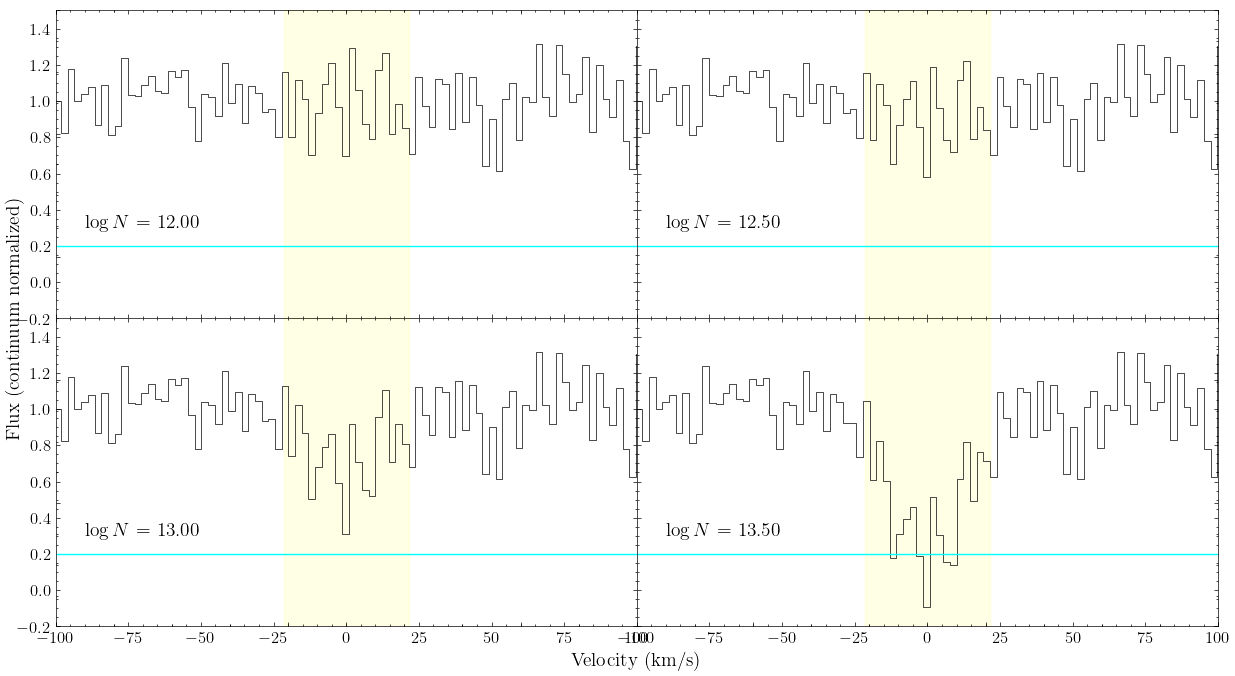

In [20]:
# Pick a trial at random
sample_trial_idx = np.random.randint(low=0, high=N_trials, size=1)[0]

fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

for i in range(len(logN_plot_grid)):
    
    ax = axes[i//2, i%2]
    
    # Find the closest logN for which the trial was run
    sample_logN_idx = np.argmin(np.abs(logN_grid-logN_plot_grid[i]))
    
    ax.step(v, flux_grid[sample_trial_idx, sample_logN_idx, :], where='mid', lw=.5)

    ax.step(v, err_std*np.ones(len(v)), where='mid', color='cyan')
    
    ax.axvspan(xmin=-fwhm, xmax=fwhm, color='yellow', alpha=.1)
    
    ax.text(x=-90, y=0.3, s=r'$\log N$ = '+'{:.2f}'.format(logN_plot_grid[i]))

    ax.set_xlim(-100,100)
    ax.set_ylim(-0.2, 1.5)
    
ax_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_label.set_xlabel('Velocity (km/s)')
ax_label.set_ylabel('Flux (continuum normalized)')
plt.subplots_adjust(wspace=0, hspace=0)

Now start calculating significance

In [21]:
P_null_grid = np.zeros((N_trials, len(logN_grid)))
P_alt_grid = np.zeros((N_trials, len(logN_grid)))

In [22]:
for i in range(N_trials):
    for j in range(len(logN_grid)):
        P_null_grid[i,j] = np.exp(-0.5*np.sum((flux_grid[i,j,:][idx]-1)**2/err_std**2))
        P_alt_grid[i,j] = np.exp(-0.5*np.sum((flux_grid[i,j,:][idx]-model_grid[j,:][idx])**2/err_std**2))

In [23]:
significance_grid = 2*(np.log(P_alt_grid)-np.log(P_null_grid))
significance_medians = np.array([np.median(significance_grid[:,i]) for i in range(len(logN_grid))])

In [24]:
sig_med_inv_interp = interpolate.interp1d(x=significance_medians, y=logN_grid, fill_value='extrapolate')

In [25]:
logN_1sig = sig_med_inv_interp(1)
logN_2sig = sig_med_inv_interp(4)
logN_3sig = sig_med_inv_interp(9)

Text(0, 0.5, '$\\Delta \\chi^2$')

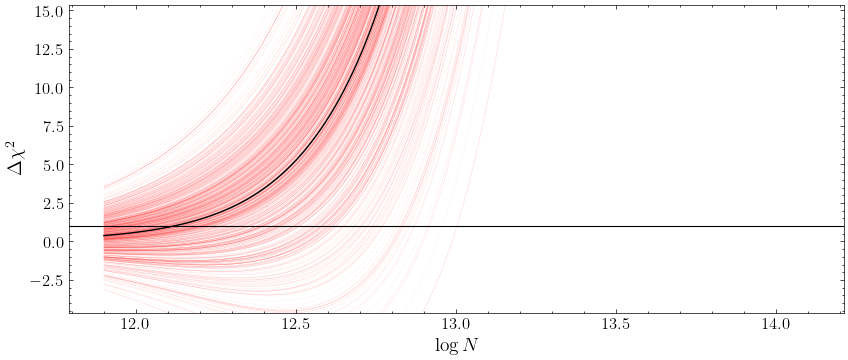

In [38]:
# Plot results from some Monte carlo runs

N_trials_plot = 1000
trials_idx = np.random.randint(low=0, high=N_trials, size=N_trials_plot)

fig, ax = plt.subplots(1, figsize=(10,4))

#ax.violinplot([significance_grid[:,j] for j in range(len(logN_grid))], positions=logN_grid, widths=0.2)
for i in range(N_trials_plot):
    ax.plot(logN_grid, significance_grid[trials_idx[i],:], lw=.2, color='red', alpha=.1)

ax.plot(logN_grid, significance_medians)

#ax.set_xlim(np.min(logN_grid), 12.8)
ax.set_ylim(np.min(significance_medians)-5, np.min(significance_medians)+15)

ax.axhline(1, lw=.8)

ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$\Delta \chi^2$')

In [34]:
logN_1sig, logN_2sig, logN_3sig

(array(12.11814616), array(12.43512888), array(12.62862677))

In [35]:
logN_2sig-logN_1sig, logN_3sig-logN_2sig

(0.31698272242286585, 0.193497886935031)

(-0.2, 1.5)

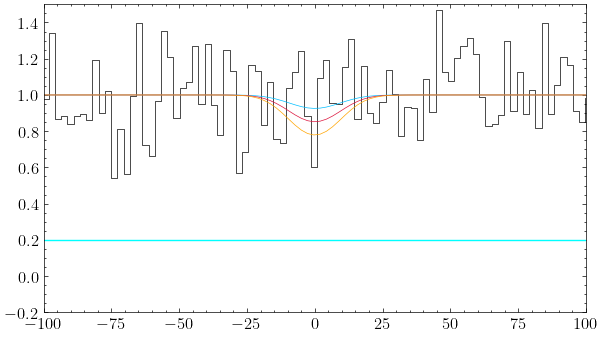

In [36]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.step(v, 1+noise_grid[np.random.randint(low=0, high=N_trials, size=1)[0],:], 
            where='mid', lw=.5)

ax.plot(v, vp(v, logN_1sig), lw=.5)
ax.plot(v, vp(v, logN_2sig), lw=.5)
ax.plot(v, vp(v, logN_3sig), lw=.5)

ax.step(v, err_std*np.ones(len(v)), where='mid', color='cyan')

#ax.legend()
ax.set_xlim(-100,100)
ax.set_ylim(-0.2, 1.5)